In [1]:
from data import generate_distributions

from numpy import histogram, diff, exp, linspace
from pandas import DataFrame
from matplotlib import pyplot as plt
import pymc as pm
from IPython.display import display, clear_output
import ipywidgets as widgets

from functools import partial

%matplotlib inline

In [2]:
num_samples = 300

In [5]:
no_drift_button = widgets.Button(description="Acceptable Drift")
drift_button = widgets.Button(description="Unacceptable Drift")

In [6]:
count_trials = 0
data = []

In [24]:
main_data, alternate_data, psi, hellinger = generate_distributions(num_samples)


def on_clicked(button, label):
    global psi
    global data
    global count_trials
    
    clear_output()

    # Log values
    data.append(dict(
      label=label,
      psi=psi[0]
    ))
    count_trials += 1
    
    main_data, alternate_data, psi, hellinger = generate_distributions(num_samples)
    
    plt.close()
    
    main_hist, main_bin_edges = histogram(main_data)
    main_width = diff(main_bin_edges)
    main_center = (main_bin_edges[:-1] + main_bin_edges[1:]) / 2
    plt.bar(main_center, main_hist, align='center', width=main_width, alpha=0.5)
    
    alt_hist, alt_bin_edges = histogram(alternate_data)
    alt_width = diff(alt_bin_edges)
    alt_center = (alt_bin_edges[:-1] + alt_bin_edges[1:]) / 2
    plt.bar(alt_center, alt_hist, align='center', width=alt_width, alpha=0.5)
    plt.draw()
    
    display(no_drift_button)
    display(drift_button)
        
no_drift_button.on_click(partial(on_clicked, label=0))
drift_button.on_click(partial(on_clicked, label=1))

Button(description='Acceptable Drift', style=ButtonStyle())

Button(description='Unacceptable Drift', style=ButtonStyle())

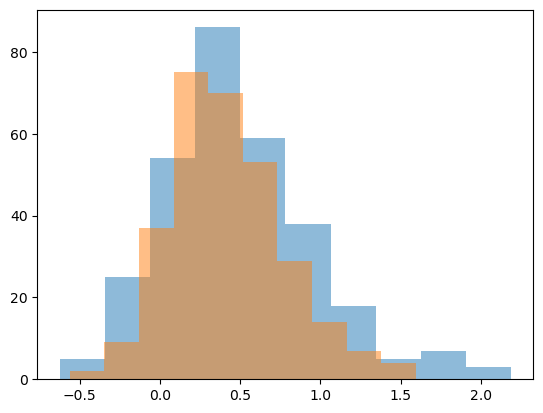

In [25]:
main_hist, main_bin_edges = histogram(main_data)
main_width = diff(main_bin_edges)
main_center = (main_bin_edges[:-1] + main_bin_edges[1:]) / 2
plt.bar(main_center, main_hist, align='center', width=main_width, alpha=0.5)

alt_hist, alt_bin_edges = histogram(alternate_data)
alt_width = diff(alt_bin_edges)
alt_center = (alt_bin_edges[:-1] + alt_bin_edges[1:]) / 2
plt.bar(alt_center, alt_hist, align='center', width=alt_width, alpha=0.5)
# plt.draw()

display(no_drift_button)
display(drift_button)

In [15]:
for d in data:
    d["psi"] = d["psi"]

In [16]:
df = DataFrame(data)

In [19]:
def logistic(x, beta):
    return 1.0 / (1 + exp(beta * x))

In [20]:
with pm.Model() as model:
    beta = pm.Normal("beta", -5, 10)
    sigma = pm.HalfCauchy("sigma", beta=10)
    
    y = pm.Normal("y", mu=logistic(df["psi"], beta), sigma=sigma, observed=df["label"])
    
    idata = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 27 seconds.


In [21]:
mean_beta = idata.posterior.beta.mean()

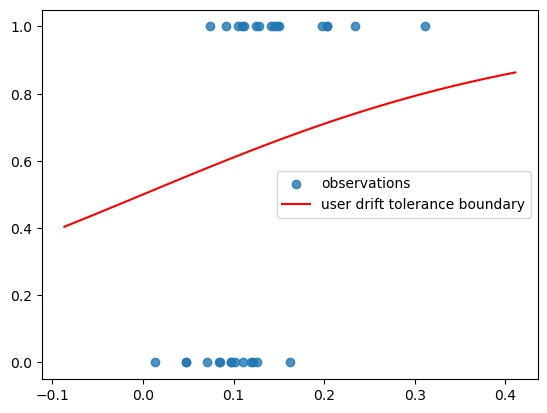

In [26]:
xmin = df["psi"].min()
xmax = df["psi"].max()

plt.scatter(df["psi"], df["label"], label="observations", alpha=0.8)

log_x = linspace(xmin - 0.1, xmax + 0.1, 100)
# log_x = linspace(-10, 10, 200)
log_y = logistic(log_x, float(mean_beta))
# log_y = logistic(log_x, -5)

plt.plot(log_x, log_y, label="user drift tolerance boundary", color="red")
plt.legend()